#### The Need for MapReduce
* CPUs execute operations on data loaded into RAM
* Large datasets must be read from disk into RAM
* Issues arise when data cannot fit into RAM
* CPU cost is often discussed, but I/O cost is generally overlooked
* Reading large files is I/O-bound, not necessarily CPU-bound
* Disk I/O speed limits data processing


#### Disk Speed Benchmarking
* Open-source disk speed benchmarking with `fio`
  * [How Fast are Your Disks?](https://arstechnica.com/gadgets/2020/02/how-fast-are-your-disks-find-out-the-open-source-way-with-fio/) (2/6/2020)
  * FIO: Flexible I/O is a tool that helps you benchmark and verify disk I/O performance.
  * A really useful tool for data engineers
  
```bash
fio --name=test --ioengine=sync --rw=randwrite --bs=4k --numjobs=1 --size=100m --time_based --runtime=60s
```



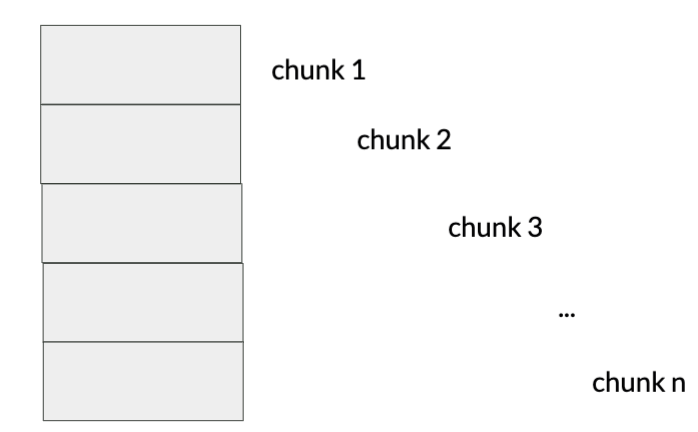

### Issue with Batching and I/O Costs
* While CPU costs are often a focal point in discussions about performance, the cost of I/O (Input/Output) is frequently overlooked.
* Even operations that are not CPU-intensive can become bottlenecks when dealing with large files due to the limitations of I/O speed.
* A standard 7200 RPM HDD typically offers a read/write speed ranging from 80 to 160 MB/s.
* Higher-end drives, like 15k RPM HDDs or SSDs, can offer significantly faster speeds, averaging around 350 MB/s.
Reading a very large file can be time-consuming.
* At a speed of 200 MB/s, it would take approximately 11 GB per minute or around 703 GB per hour to read a file.
  * For example, reading a 200 TB file would require more than 200 hours.
* Another challenge is memory constraints
  * Since it's often infeasible to store large files in RAM, each operation on the file necessitates reading the entire file from disk again.

#### Using GNU Parallel
* GNU Parallel allows concurrent execution of commands or shell scripts
    * Local and distributed execution via SSH
    * [GNU Parallel Tutorial](https://www.admin-magazine.com/HPC/Articles/GNU-Parallel-Multicore-at-the-Command-Line-with-GNU-Parallel)
    * [Parallel-SSH](https://www.tecmint.com/run-commands-on-multiple-linux-servers/)



#### GNU Parallel Example: Word Count

```bash
# Remove empty lines
awk NF t8.shakespeare.txt > text_no_empty_lines.txt
# Split into chunks
split -l 500 text_no_empty_lines.txt text_subset_
# Process chunks using Parallel
ls text_subset* | grep -v map | parallel "awk 'BEGIN {RS=\"[[:punct:][:space:]]+\"} {print \$0}' {} > {}.map"
ls *.map | parallel "sort {} | uniq -c > {}.counts"
```


* Combining all the counts can be then achived using:
```bash
cat *.counts | sort -k2,2 | awk '{counts[$2]+=$1} END {for (word in counts) print counts[word], word}' | sort -k1,1nr -k2,2
```


### Parallel and SSH

* Parallel gas the capability to distribute tasks across multiple machines using SSH

```bash
ls text_subset* | parallel --sshloginfile sshnodes \
     --dry-run \
     --transfer \
     --return {}.map \
     --cleanup \
      "<command>"
````

* Need to handle file transer, program installtion on remote machines, etc.



### Challenges in the Current Approach
* Complexity of Distributed Programming
  * Even for straightforward examples like the one discussed, there are multiple steps involved: splitting the data, transferring it, and finally merging the results.

* Lack of Redundancy
  * With a server failure rate of once every 3 years, a system with 1000 servers would experience approximately one failure per day.
    * For context, Google manages an estimated 2.5 million machines. [Source](https://www.datacenterknowledge.com/archives/2017/03/16/google-data-center-faq)
* Data Transfer Overheads
  * Shuttling data back and forth adds significant computational costs.


### What is an HPC Cluster
* High-Performance Computing (HPC)aggregating computing power to solve complex problems in science, engineering, or other fields
  * HPC systems often consist of clusters of computers that work in parallel to perform tasks more quickly and efficiently than using a single machine.
* Example of a cluster topology [Apollo2](https://docs.hpc.sussex.ac.uk/apollo2/)
<div align="center">
    <img src="https://docs.hpc.sussex.ac.uk/apollo2/_images/hpc-diagram.png" width=800?>
</div>

#### The HPC Approach
* Distribute file chunks across multiple machines.
* Each machine processes its chunk independently.
* Effective for batch-like operations.
* Pros:
  * This approch is often called embarrassingly or delightfully or pleasingly parallel.
  * Requires little effort to parallelize.
* Cons:
  * Distributed programs are complex to manage.
    * E.g.: how do we split data, how do transer it, how do we know it completed successfully, what happens if a server dies? 
  * Lack of redundancy and fault tolerance.

#### MapReduce to the Rescue
* Framework on top of HPC clusters
* Addresses fault tolerance, data redundancy
* Map Reduce Components
    * Distributed File System
        * Data chunks replicated across nodes
        * Metadata managed by master nodes
    * Mapping and Reducing
        * Mapping: Assign initial values to keys
        * Reducing: Aggregate initial values

#### Open-Source MapReduce Implementations
* Hadoop
    * Implemented in Java
    * Hadoop Distributed File System (HDFS)
* High-Level Abstractions
    * Hive: SQL-like language
    * Pig: Pig-Latin scripting language

### What a MapReduce Framework Needs to Provide:
* Data Partitioning: Keeping track of data chunks and their locations on different machines.
* Task Scheduling: Distributing program execution across available nodes.
* Node Availability: If there are more chunks than nodes, monitor when a node finishes its task to assign a new chunk.
* Result Management: Observing execution to process the results.
* Inter-Machine Communication: Managing necessary data exchange between machines.
* Failure Recovery: Handling node failures by reassigning their tasks to other available machines.
* Developer-Friendly: The framework requires developers to write only the map and reduce functions.
  * Provide implementation of common operations
  * E.g., what happens during a `group by`?


In [8]:
# On Linux
# !head -c 1G </dev/urandom > /tmp/myfile
# BE EXTRA CARFUL WITH THE FOLLOWIN
!dd if=/dev/zero of=/tmp/temp_10GB_file bs=1024 count=10485760


10485760+0 records in
10485760+0 records out
10737418240 bytes transferred in 25.492404 secs (421200693 bytes/sec)


In [15]:
!du -sch /tmp/temp_10GB_file

In [14]:
%%timeit
# Running on a solid state drive.
for _ in open("/tmp/temp_10GB_file", "rb").readlines():
  pass


9.08 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Map Reduce -- Distributed file system
* Chunks are (16-64 MB) replicated across chunk servers (compute nodes)
  * Typically 3 replicates per chunk
  * No two chunks are on the same machine
  * preferably across node racks
* Catalogue of where each chunk is stored on a master nodes

### MapReduce Through an Example: Word Counting 

* Use Case: Counting words in a large document
  * Analogous to the task of reading K-mers in a DNA sequence
* Memory Constraints: Word counts exceed available RAM, requiring multiple machines.
* Chunk Management: The main cluster node keeps track of the location of each data chunk.
* Mapping Step: Individual nodes perform the 'mapping' of words to initial counts.
* Reducing Step: Specific nodes take on the task of 'reducing' initial counts to final totals.

<div align="center">
    <img src="https://www.dropbox.com/s/jwop5elec8trs5m/map_recude_words_example.png?dl=1" width=850>
</div>

### The Key-Value Pair in Hadoop
* The Key-Value pair <K, V> is the core entity processed by a MapReduce job.
  * Both map and reduce phases use Key-Value pairs for input and output.
  * All data in MapReduce is formatted as a Key-Value pair <K, V>

* Keys are used to partition data so that all values with the same key go to the same reducer.
* Keys also sort the data, grouping values by their associated key for easier processing by the reducer.
* The reducer combines all values associated with the same key into a single value.
* The reducer performs computations like sum, average, etc., on all values associated with the same key to produce the final result.


### Roles of the Map-Reduce Framework
* Data Partitioning: Divides the data into chunks and keeps track of their locations.
* Task Scheduling: Coordinates the program's execution across multiple nodes.
* Execution Monitoring: Oversees the runtime progress of tasks.
* Grouping by Keys: Organizes data based on specified keys during the reduce phase.
* Intermachine Communication: Manages data and control flow between nodes.
* Fault Handling: Addresses node failures and reallocates tasks as needed.

### Role of Master Node

* Keeps track of the status of the task
  * idle, in progress, or completed
* Idle tasks are scheduled as workers become available
* When a map task completes it sends the master the location of its R intermediate files
  * Each of the R intermediate files is associated with the reducer task
  * The master pushes info to reducers
  * Reduced do not start computaiton (or file copies) until all map tasks are completed
* Master pings workers to detect compute node failures
  * Resets to idle all map tasks that ran on that compute node
  * Resets to idle in progress reduce tasks on the compute node

### MapReduce Exercices

* Can you Compute the MapReduce version of `max`?
* Can you compute the MapReduce version of `median`?
* Can you develop a MapReduce recommendation system where if A is friends with B and B is friends with C, then A gets a recommendation to be friends with C?


### MapReduce Max Mappers Across Nodes

* Data (`[4, 2, 2, 9, 1, 5, 5]`) partitioned across reducers

```bash
Node 1: Input: [4, 2, 2]
        Output: [('max', 4), ('max', 2), ('max', 2)]

Node 2: Input: [9, 1]
        Output: [('max', 9), ('max', 1)]

Node 3: Input: [5, 5]
        Output: [('max', 5), ('max', 5)]
```

### MapReduce Max - Reducers on Individual Nodes
```bash
Node 1: Input: [('max', 4), ('max', 2), ('max', 2)]
        Intermediate Steps:
            max_so_far = 4
            max_so_far = max(4, 2) = 4
            max_so_far = max(4, 2) = 4
        Output: [('max', 4)]

Node 2: Input: [('max', 9), ('max', 1)]
        Intermediate Steps:
            max_so_far = 9
            max_so_far = max(9, 1) = 9
        Output: [('max', 9)]

Node 3: Input: [('max', 5), ('max', 5)]
        Intermediate Steps:
            max_so_far = 5
            max_so_far = max(5, 5) = 5
        Output: [('max', 5)]
```

### Example: MapReduce Median

* Map each number in the input data to a key-value pair where the key is the number itself and the value is the count of 1. 
  * Assume a small number of unique values
```bash
Input: [4, 2, 2, 9, 1, 5, 5]
Output: [(4, 1), (2, 1), (2, 1), (9, 1), (1, 1), (5, 1), (5, 1)]
```
* Reducer takes the key-value pairs and sums the values for each key. This will give the count of each unique number.
```bash
Input: [(4, 1), (2, 1), (2, 1), (9, 1), (1, 1), (5, 1), (5, 1)]
Output: [(1, 1), (2, 2), (4, 1), (5, 2), (9, 1)]
```
* Sort the list based on the keys(assumes relativey small number of values)
```bash
Sorted Output: [(1, 1), (2, 2), (4, 1), (5, 2), (9, 1)]
```
* Compute the median based on the counts and keys.

### MapReduce Friend Recommendation

* Goal: Recommend new friends based on existing friendships
* Input Friendship Pairs `[(A, B), (B, C), (B, D), (C, E)]`

* Mapper:
  * Emit the existing friendship

 ```
  [(A, B), (B, A),
   (B, C), (C, B),
   (B, D), (D, B),
   (C, E), (E, C)]
```


### MapReduce Friend Recommendation -- Mapper

* Map here emmits friend-of-friend recommendations. For instance:

```
# For (B, C):
Emit existing friendship: (B, C), (C, B)
Emit friend-of-friend for B: (A, C), (D, C)
Emit friend-of-friend for C: (B, E)
```

```
# For (B, D):
Emit existing friendship: (B, D), (D, B)
Emit friend-of-friend for B: (A, D), (C, D)
Emit friend-of-friend for D: 
```

...

### MapReduce Friend Recommendation -- Reducer

* Original input `[(A, B), (B, C), (B, D), (C, E)]`

Reducer Input: `[(A, B), (A, C), (A, D), (B, C), (B, E), (C, B), (D, C), (E, C)]`

* Reduce by filtering out exisiting friendships (Compute difference)
  *  Resort order of pairs: e.g., (C, B) should be (B, C) so difference words easily.
  
Emit: `[(A, C), (A, D), (B, E), (D, C)]`



### Map Reduce Refinements - 2
* The system's default partition function is `hash(key) mod R`.
  * This assigns each key to a reducer from a range [0, R-1].
* This can lead to an unbalanced load, where certain reducers get overwhelmed with keys.
* In some cases, using a custom partition function can be beneficial:
* For example, if processing tweets by language, you'd want all tweets of the same language on the same reducer.
  * Use: hash(language) mod R
* To address the unbalanced load issue, a custom function could better distribute keys across reducers.

### Open Source Map-Reduce Implementations

* Hadoop: 
  * Open source implementation in Java
  * Uses the Hadoop Distributed File System (HDFS)
  * Files are stored as AVRO files
    * Row-based format makes it easy to chunk the files
  * Available on most cloud services platforms
    * [Amazon Elastic Map Reduce (EMR) services](https://aws.amazon.com/emr/features/hadoop/)
    * Google [Dataproc](https://cloud.google.com/dataproc), the managed Spark and Hadoop service 
    * Microsoft Azure [HDInsight](https://azure.microsoft.com/en-us/services/hdinsight/)
   


### Open Source Map-Reduce Implementations

* Hive
  * An Apache project offering SQL-like abstractions over MapReduce.
  * Simplifies common Hadoop tasks.
  * No need to manually code operations like select, join, filter, and aggregate.
  * Ideal for interactive queries and report generation.
* Pig
  * Uses its own scripting language, Pig Latin, to process data.
  * Offers a different approach than Hive but aims to simplify similar tasks.

* Both Hive and Pig are accessible via various cloud service providers.
  * Using these services on the cloud incurs costs related to:
    * Computation (CPU time)
    * Disk storage
    * File transfer

In [7]:
from collections import defaultdict
from typing import List, Tuple, Iterable, Any

class SimpleMapReduce:
    """
    SimpleMapReduce is a minimalistic framework designed to implement 
    the MapReduce programming model. This class provides the base 
    functionalities for a MapReduce job, including mapping, shuffling,
    and reducing phases.
    
    Methods:
        getData(input_data: List[Any]) -> Iterable[Tuple[int, Any]]:
            Enumerates the input data, which can be of any type.
        
        flatMapper(k1: int, v1: Any) -> Iterable[Tuple[Any, Any]]:
            Takes a key-value pair and returns an iterable of key-value pairs.
            Must be implemented by subclasses.
        
        reducer(k2: Any, v2s: Iterable[Any]) -> Tuple[Any, Any]:
            Reduces a list of values that share the same key to a single 
            key-value pair. Must be implemented by subclasses.
            
        _flatMap(mass_k1v1: Iterable[Tuple[int, Any]]) -> List[Tuple[Any, Any]]:
            Helper function that applies the flatMapper function to the input data.
        
        _shuffle(mapped: List[Tuple[Any, Any]]) -> Iterable[Tuple[Any, List[Any]]]:
            Helper function that groups the mapped data by keys.
            
        _reduce(mass_k2v2s: Iterable[Tuple[Any, List[Any]]]) -> List[Tuple[Any, Any]]:
            Helper function that applies the reducer function to the shuffled data.
        
        _run(input_data: List[Any]) -> List[Tuple[Any, Any]]:
            Executes the MapReduce job in the order of mapping, shuffling, and reducing.
            
    To use this class, you must subclass it and implement the flatMapper and 
    reducer methods.
    """

    
    @staticmethod
    def getData(input_data: List[Any]) -> Iterable[Tuple[int, Any]]:
        return enumerate(input_data)
    
    @staticmethod
    def flatMapper(k1: int, v1: Any) -> Iterable[Tuple[Any, Any]]:
        raise NotImplementedError()
        
    @staticmethod
    def reducer(k2: Any, v2s: Iterable[Any]) -> Tuple[Any, Any]:
        raise NotImplementedError()
    
    @classmethod
    def _flatMap(cls, mass_k1v1: Iterable[Tuple[int, Any]]) -> List[Tuple[Any, Any]]:
        output = []
        for k1, v1 in mass_k1v1:
            for k2, v2 in cls.flatMapper(k1, v1):
                output.append((k2, v2))
        return output
    
    @classmethod
    def _shuffle(cls, mapped: List[Tuple[Any, Any]]) -> Iterable[Tuple[Any, List[Any]]]:
        d = defaultdict(list)
        for k2, v2 in mapped:
            d[k2].append(v2)
        return d.items()
    
    @classmethod
    def _reduce(cls, mass_k2v2s: Iterable[Tuple[Any, List[Any]]]) -> List[Tuple[Any, Any]]:
        output = []
        for k2, v2s in mass_k2v2s:
            output.append(cls.reducer(k2, v2s))
        return output
    
    @classmethod
    def _run(cls, input_data: List[Any]) -> List[Tuple[Any, Any]]:
        # Load data
        data = cls.getData(input_data)
        
        # Map
        mapped = cls._flatMap(data)
        
        # Shuffle
        shuffled = cls._shuffle(mapped)
        
        # Reduce
        reduced = cls._reduce(shuffled)
        
        return reduced

In [4]:
class WordCountMapReduce(SimpleMapReduce):
    
    @staticmethod
    def flatMapper(k1: int, v1: str) -> Iterable[Tuple[str, int]]:
        words = v1.split()
        for word in words:
            yield (word.lower(), 1)
            
    @staticmethod
    def reducer(k2: str, v2s: List[int]) -> Tuple[str, int]:
        return k2, sum(v2s)
    
    @classmethod
    def post_process():
        pass

In [8]:
input_data = ["Hello world", "Python MapReduce example", "Hello MapReduce", "Simple example"]

my_sample_data = WordCountMapReduce.getData(input_data)


In [10]:
list(my_sample_data)

[(0, 'Hello world'),
 (1, 'Python MapReduce example'),
 (2, 'Hello MapReduce'),
 (3, 'Simple example')]

In [16]:
list(WordCountMapReduce.flatMapper(0, "yellow"))


[('yellow', 1)]

In [104]:
WordCountMapReduce.reducer("A", [1,1,1,1])

('A', 4)

In [17]:
my_sample_data = WordCountMapReduce.getData(input_data)
my_sample_data_mapped = WordCountMapReduce._flatMap(my_sample_data)
my_sample_data_mapped

[('hello', 1),
 ('world', 1),
 ('python', 1),
 ('mapreduce', 1),
 ('example', 1),
 ('hello', 1),
 ('mapreduce', 1),
 ('simple', 1),
 ('example', 1)]

In [18]:
my_sample_data_mapped_shuffled =  WordCountMapReduce._shuffle(my_sample_data_mapped)
my_sample_data_mapped_shuffled

dict_items([('hello', [1, 1]), ('world', [1]), ('python', [1]), ('mapreduce', [1, 1]), ('example', [1, 1]), ('simple', [1])])

In [19]:
 WordCountMapReduce._reduce(my_sample_data_mapped_shuffled)

[('hello', 2),
 ('world', 1),
 ('python', 1),
 ('mapreduce', 2),
 ('example', 2),
 ('simple', 1)]

In [108]:
input_data = ["Hello world", "Python MapReduce example", "Hello MapReduce", "Simple example"]

WordCountMapReduce._run(input_data)


[('hello', 2),
 ('world', 1),
 ('python', 1),
 ('mapreduce', 2),
 ('example', 2),
 ('simple', 1)]

In [109]:

class ComputeMedian(SimpleMapReduce):
    
    @staticmethod
    def flatMapper(k1: int, v1: int) -> Iterable[Tuple[int, int]]:
        yield (v1, 1)
            
    @staticmethod
    def reducer(k2: int, v2s: List[int]) -> Tuple[int, int]:
        return k2, sum(v2s)

    @classmethod
    def post_process(cls, reduced_output: List[Tuple[Any, Any]]) -> float:

        # Sort by key
        sorted_reduced = sorted(reduced_output)

        # Compute Median
        total_count = sum(v for k, v in sorted_reduced)
        median = None
        count_so_far = 0
        for k, v in sorted_reduced:
            count_so_far += v
            if total_count % 2 == 1:  # Odd total count
                if count_so_far * 2 > total_count:
                    median = k
                    break
            else:  # Even total count
                if count_so_far * 2 == total_count:
                    median = k / 2
                elif count_so_far * 2 > total_count:
                    median += k / 2
                    break

        return median


In [110]:
input_data = [3, 2, 4, 1, 5, 6, 8, 1, 3, 4, 6]
my_sample_data = ComputeMedian.getData(input_data)
list(my_sample_data)


[(0, 3),
 (1, 2),
 (2, 4),
 (3, 1),
 (4, 5),
 (5, 6),
 (6, 8),
 (7, 1),
 (8, 3),
 (9, 4),
 (10, 6)]

In [111]:
my_sample_data = ComputeMedian.getData(input_data)
my_sample_data_mapped = ComputeMedian._flatMap(my_sample_data)
my_sample_data_mapped

[(3, 1),
 (2, 1),
 (4, 1),
 (1, 1),
 (5, 1),
 (6, 1),
 (8, 1),
 (1, 1),
 (3, 1),
 (4, 1),
 (6, 1)]

In [112]:
my_sample_data_mapped_shuffled =  ComputeMedian._shuffle(my_sample_data_mapped)
my_sample_data_mapped_shuffled

dict_items([(3, [1, 1]), (2, [1]), (4, [1, 1]), (1, [1, 1]), (5, [1]), (6, [1, 1]), (8, [1])])

In [113]:
ComputeMedian._reduce(my_sample_data_mapped_shuffled)

[(3, 2), (2, 1), (4, 2), (1, 2), (5, 1), (6, 2), (8, 1)]

In [116]:
input_data = [3, 2, 4, 1, 5, 6, 8, 1, 3, 4, 6]

reduced_output = ComputeMedian._run(input_data)
reduced_output

[(3, 2), (2, 1), (4, 2), (1, 2), (5, 1), (6, 2), (8, 1)]

In [117]:
ComputeMedian.post_process(reduced_output)

4

In [120]:
import statistics
statistics.median([3, 2, 4, 1, 5, 6, 8, 1, 3, 4, 6])

4

In [271]:
from typing import Set
class CollectExistingFriendships(SimpleMapReduce):

    @staticmethod
    def flatMapper(k1: int, v1: Tuple[str, str]) -> Iterable[Tuple[str, str]]:
        friend1, friend2 = v1
        yield (friend1, friend2)
        yield (friend2, friend1)
        
    @staticmethod
    def reducer(k2: str, v2s: Iterable[str]) -> Tuple[str, Set[str]]:
        return k2, set(v2s)


In [273]:
input_data = [("A", "B"), ("B", "C"), ("B", "D"), ("C", "E")]
my_sample_data = CollectExistingFriendships.getData(input_data)
my_sample_data_mapped = CollectExistingFriendships._flatMap(my_sample_data)
my_sample_data_mapped

[('A', 'B'),
 ('B', 'A'),
 ('B', 'C'),
 ('C', 'B'),
 ('B', 'D'),
 ('D', 'B'),
 ('C', 'E'),
 ('E', 'C')]

In [274]:
my_sample_data_mapped_shuffled =  CollectExistingFriendships._shuffle(my_sample_data_mapped)
my_sample_data_mapped_shuffled

dict_items([('A', ['B']), ('B', ['A', 'C', 'D']), ('C', ['B', 'E']), ('D', ['B']), ('E', ['C'])])

In [275]:
reduced_data_stage_1 = CollectExistingFriendships._reduce(my_sample_data_mapped_shuffled)
reduced_data_stage_1

[('A', {'B'}),
 ('B', {'A', 'C', 'D'}),
 ('C', {'B', 'E'}),
 ('D', {'B'}),
 ('E', {'C'})]

In [313]:
class GenerateFriendMappings(SimpleMapReduce):
    @staticmethod
    def flatMapper(k1: int, v1: Tuple[str, Set[str]]) -> Iterable[Tuple[str, str]]:
        person, friends = v1
        for friend in friends:
            for potential_friend in friends:
                if friend != potential_friend:
                    yield (friend, potential_friend)

    @staticmethod
    def reducer(k2: str, v2s: Iterable[str]) -> Tuple[str, Set[str]]:
        return k2, set(v2s)


In [314]:
reduced_data_stage_1

[('A', {'B'}),
 ('B', {'A', 'C', 'D'}),
 ('C', {'B', 'E'}),
 ('D', {'B'}),
 ('E', {'C'})]

In [301]:
my_sample_data = GenerateFriendMappings.getData(reduced_data_stage_1)
my_sample_data_mapped = GenerateFriendMappings._flatMap(my_sample_data)
my_sample_data_mapped


[('C', 'D'),
 ('C', 'A'),
 ('D', 'C'),
 ('D', 'A'),
 ('A', 'C'),
 ('A', 'D'),
 ('E', 'B'),
 ('B', 'E')]

In [302]:
my_sample_data_mapped_shuffled =  GenerateFriendMappings._shuffle(my_sample_data_mapped)
my_sample_data_mapped_shuffled

dict_items([('C', ['D', 'A']), ('D', ['C', 'A']), ('A', ['C', 'D']), ('E', ['B']), ('B', ['E'])])

In [303]:
reduced_data_stage_2 = GenerateFriendMappings._reduce(my_sample_data_mapped_shuffled)
reduced_data_stage_2

[('C', {'A', 'D'}),
 ('D', {'A', 'C'}),
 ('A', {'C', 'D'}),
 ('E', {'B'}),
 ('B', {'E'})]

In [373]:
class UniqueFriendRecommendations(SimpleMapReduce):
    
    @staticmethod
    def flatMapper(k1: int, v1: Tuple[str, Set[str]]) -> Iterable[Tuple[str, Tuple[str, str]]]:
        person, recommendations = v1
        for recommended in recommendations:
            yield (person, recommended)
            
    @staticmethod
    def reducer(k2: str, v2s: Iterable[Tuple[str, str]]) -> Tuple[str, Set[Tuple[str, str]]]:
        pass
                
    def post_process(new_recommendations: Iterable[Tuple[str, str]], 
                     original_list: Iterable[Tuple[str, str]]) -> Iterable[Tuple[str, str]]:
        sorted_new_recommendations = set([tuple(sorted(x)) for x in new_recommendations])
        sorted_original_list = set([tuple(sorted(x)) for x in original_list])
        return sorted_new_recommendations.difference(sorted_original_list)
        
        

In [374]:
reduced_data_stage_2

[('C', {'A', 'D'}),
 ('D', {'A', 'C'}),
 ('A', {'C', 'D'}),
 ('E', {'B'}),
 ('B', {'E'})]

In [375]:
my_sample_data = GenerateFriendMappings.getData(reduced_data_stage_2)
my_sample_data_mapped = UniqueFriendRecommendations._flatMap(my_sample_data)
my_sample_data_mapped


[('C', 'A'),
 ('C', 'D'),
 ('D', 'C'),
 ('D', 'A'),
 ('A', 'C'),
 ('A', 'D'),
 ('E', 'B'),
 ('B', 'E')]

In [377]:
reduced_data_stage_1

[('A', {'B'}),
 ('B', {'A', 'C', 'D'}),
 ('C', {'B', 'E'}),
 ('D', {'B'}),
 ('E', {'C'})]

In [376]:
UniqueFriendRecommendations.post_process(my_sample_data_mapped, input_data)

{('A', 'C'), ('A', 'D'), ('B', 'E'), ('C', 'D')}